In [1]:
import os 
from glob import glob
import numpy as np

from models.VAE import VariationalAutoencoder
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

#mode =  'build' #'load' #
mode = 'load'

DATA_FOLDER = './data/img_align_celeba/'

In [3]:
INPUT_DIM = (128,128,3)
BATCH_SIZE = 64

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))

NUM_IMAGES = len(filenames)

In [4]:
data_gen = ImageDataGenerator(rescale=1./255)

data_flow = data_gen.flow_from_directory(
    DATA_FOLDER, 
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = 'training')

Found 202599 images belonging to 1 classes.


In [5]:
vae = VariationalAutoencoder(
    input_dim = INPUT_DIM,
    encoder_conv_filters=[32,64,64,64],
    encoder_conv_kernel_size=[3,3,3,3],
    encoder_conv_strides=[2,2,2,2],
    decoder_conv_t_filters=[64,64,32,3],
    decoder_conv_t_kernel_size=[3,3,3,3],
    decoder_conv_t_strides=[2,2,2,2],
    z_dim = 200,
    use_batch_norm=True,
    use_dropout=True)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

W0616 12:28:23.635163  3700 deprecation_wrapper.py:119] From C:\Users\brama\Miniconda3\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 12:28:23.675165  3700 deprecation_wrapper.py:119] From C:\Users\brama\Miniconda3\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 12:28:23.694158  3700 deprecation_wrapper.py:119] From C:\Users\brama\Miniconda3\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 12:28:23.706153  3700 deprecation_wrapper.py:119] From C:\Users\brama\Miniconda3\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_sessio

In [6]:
vae.encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         encoder_conv_0[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

In [7]:
vae.decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
__________

In [8]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 10000
EPOCHS = 2
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [9]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

W0616 12:28:28.157783  3700 deprecation_wrapper.py:119] From C:\Users\brama\Miniconda3\envs\generative\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [10]:
vae.train_with_generator(     
    data_flow
    , epochs = EPOCHS
    , steps_per_epoch = NUM_IMAGES / BATCH_SIZE
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Epoch 1/2
   2/3165 [..............................] - ETA: 3:35:50 - loss: 220.0046 - vae_r_loss: 160.5993 - vae_kl_loss: 59.4053

C:\Users\brama\Miniconda3\envs\generative\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194291). Check your callbacks.
  % delta_t_median)


  10/3165 [..............................] - ETA: 3:17:40 - loss: 220.8191 - vae_r_loss: 162.0055 - vae_kl_loss: 58.8136

KeyboardInterrupt: 

In [27]:
vae.save(RUN_FOLDER)

# Reconstruct

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from utils.loaders import ImageLabelLoader

In [37]:
IMAGE_FOLDER  = './data/img_align_celeba/img_align_celeba'

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

In [38]:
att.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [39]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)


Found 202599 images.


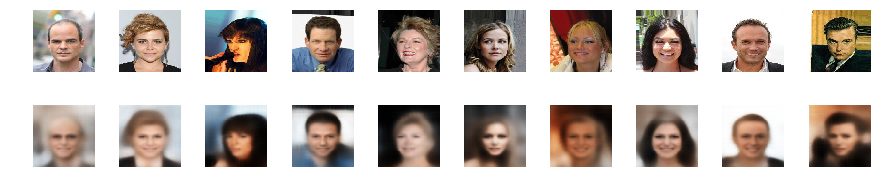

In [40]:

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15,3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.imshow(img)
    
for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i + n_to_show+1)
    sub.axis('off')
    sub.imshow(img)

20/20 [==============================] - 5s 251ms/step


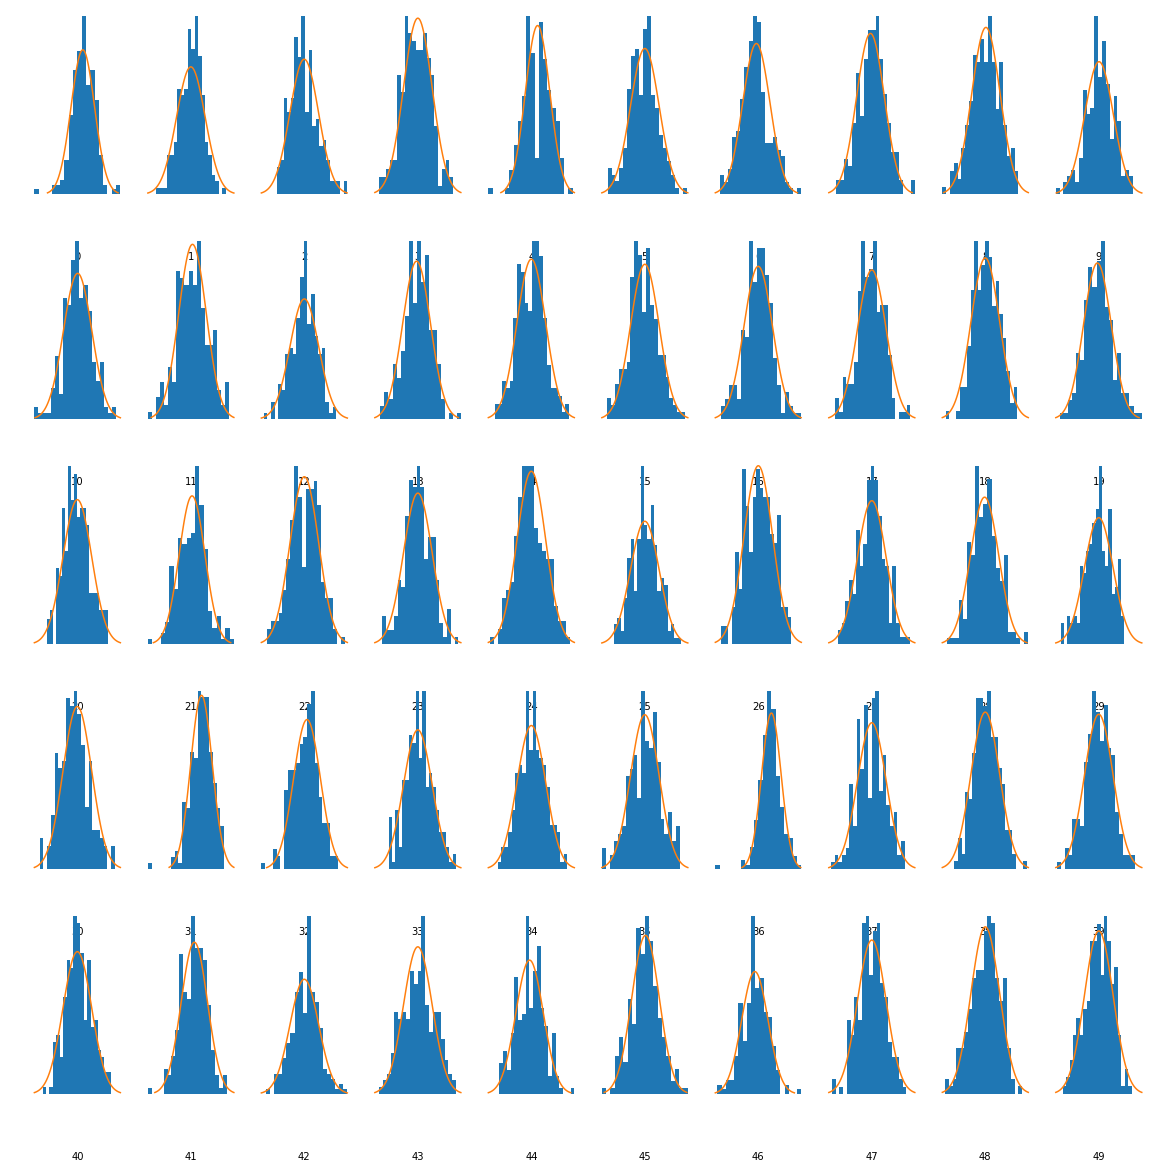

In [41]:
z_test = vae.encoder.predict_generator(data_flow_generic, steps = 20, verbose=1)

x=np.linspace(-3,3,100)

fig = plt.figure(figsize=(20,20))
#fig.subplots_adjust

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins=20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))
    
plt.show()

In [44]:
# new faces

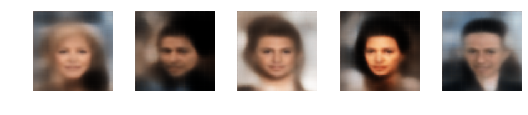

In [42]:
n_to_show = 5

znew=np.random.normal(size=(n_to_show, vae.z_dim))

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18,5))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax=fig.add_subplot(3,10,i+1)
    ax.imshow(reconst[i,:,:,:])
    ax.axis('off')

plt.show()

In [43]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   


In [44]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()


In [45]:
BATCH_SIZE = 1000
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

Found 202599 images.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
530    : 0.882    : 0.89    : 1.454    : 1.454
1055    : 0.406    : 0.457    : 1.233    : -0.221
1578    : 0.274    : 0.258    : 1.152    : -0.08
2075    : 0.175    : 0.186    : 1.121    : -0.031
2601    : 0.125    : 0.156    : 1.104    : -0.016
3152    : 0.122    : 0.112    : 1.095    : -0.009
3667    : 0.092    : 0.102    : 1.095    : -0.001
4173    : 0.082    : 0.087    : 1.087    : -0.008
4683    : 0.07    : 0.079    : 1.08    : -0.007
5198    : 0.069    : 0.071    : 1.07    : -0.01
5725    : 0.059    : 0.063    : 1.058    : -0.012
6230    : 0.053    : 0.057    : 1.062    : 0.004
6749    : 0.046    : 0.05    : 1.061    : -0.001
7246    : 0.045    : 0.048    : 1.064    : 0.003
7746    : 0.042    : 0.048    : 1.063    : -0.002
8275    : 0.039    : 0.04    : 1.063    : 0.001
Found the Attractive vector
Found 202599 images.
label: Mouth_Slightly_Open
images : POS move : NEG move :distance : 𝛥 dis

In [46]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

Found 202599 images.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
65    : 2.312    : 0.536    : 2.479    : 2.479
141    : 1.152    : 0.35    : 2.234    : -0.245
236    : 0.743    : 0.182    : 2.01    : -0.224
316    : 0.448    : 0.136    : 1.821    : -0.188
383    : 0.327    : 0.104    : 1.743    : -0.078
440    : 0.268    : 0.085    : 1.73    : -0.013
509    : 0.226    : 0.069    : 1.724    : -0.006
582    : 0.23    : 0.065    : 1.727    : 0.003
655    : 0.195    : 0.053    : 1.698    : -0.029
726    : 0.187    : 0.048    : 1.692    : -0.007
780    : 0.146    : 0.05    : 1.69    : -0.001
837    : 0.143    : 0.043    : 1.675    : -0.015
897    : 0.134    : 0.037    : 1.663    : -0.012
967    : 0.135    : 0.034    : 1.679    : 0.015
1022    : 0.111    : 0.031    : 1.685    : 0.007
1076    : 0.104    : 0.033    : 1.685    : -0.0
1147    : 0.11    : 0.025    : 1.665    : -0.02
1209    : 0.1    : 0.026    : 1.645    : -0.02
1263    : 0.075    : 0.023    : 1.661    

In [47]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 images.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
129    : 1.831    : 0.649    : 2.107    : 2.107
292    : 0.918    : 0.327    : 1.828    : -0.278
442    : 0.479    : 0.204    : 1.775    : -0.053
589    : 0.311    : 0.134    : 1.757    : -0.018
751    : 0.251    : 0.107    : 1.743    : -0.014
909    : 0.185    : 0.089    : 1.73    : -0.014
1067    : 0.172    : 0.074    : 1.707    : -0.022
1229    : 0.147    : 0.068    : 1.701    : -0.006
1374    : 0.124    : 0.051    : 1.706    : 0.005
1525    : 0.124    : 0.051    : 1.698    : -0.007
1683    : 0.11    : 0.045    : 1.696    : -0.002
1825    : 0.088    : 0.041    : 1.688    : -0.008
1974    : 0.088    : 0.04    : 1.684    : -0.005
2115    : 0.083    : 0.034    : 1.691    : 0.007
2240    : 0.078    : 0.033    : 1.69    : -0.001
2394    : 0.072    : 0.031    : 1.682    : -0.008
2542    : 0.07    : 0.03    : 1.682    : 0.0
2697    : 0.064    : 0.029    : 1.681    : -0.001
2838    : 0.057    : 0.025 

Blonde Vector


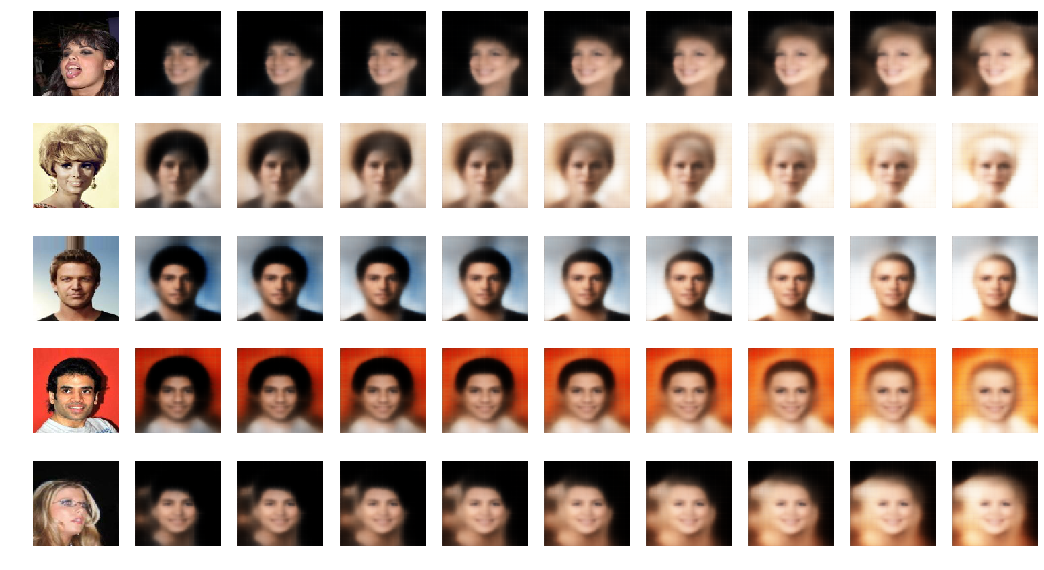

In [48]:
print('Blonde Vector')
add_vector_to_images(blonde_vec)


In [55]:

def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 images.


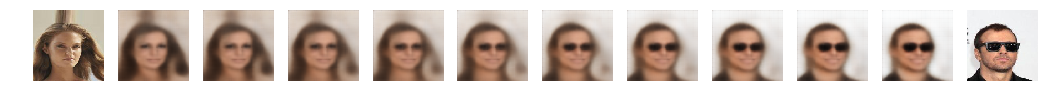

In [56]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 images.


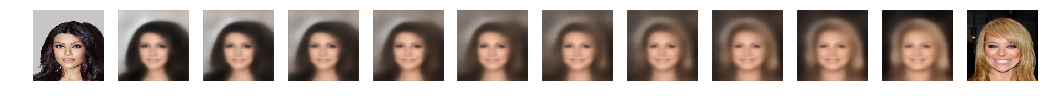

In [57]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 images.


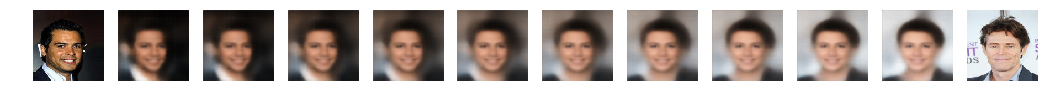

In [58]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)